In [1]:
import scipy.io
import numpy as np
from numpy.fft import fft, rfft, rfftfreq, fftfreq, fftshift
import pandas as pd
from os import listdir, path
from os.path import isfile, join
import datetime
import dateutil.parser as parser
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, hanning, welch, get_window, periodogram
import cProfile
import time
from itertools import zip_longest

# Prepare the Data

In [2]:
fs = 25000  # sampling frequency 25kHz
T = 10  # time of signal 10s
n = 999 # number of signals
N = fs * T  # number of samples
dt = 1 / fs

Single signal is in the following format:
```
signals = np.array([
            single_signal=[
                  datetime, data
                  ],
                  ...
          ])
```

## Generator extracting all data from MATLAB files
Sort the list of filenames lexicographically.
> Google Collabs changes the order for some reason (probably because of different default data storing order order on Google Drive).
> In PyCharm it works without any sorting, however this step does not take much time and does not impact the performance much.

### Change the MATLAB timestamp format to YYY-MM-dd HH:mm:ss
MATLAB provides a default timestamp format ```2020-JAN-01 00:00:00```.

My approach here is to convert it to the more useful datetime format ```YYYY:MM:dd HH:mm:ss```, in order to use the DateTimeIndex in *pandas.DataFrame* objects later.

> parser.parse(timestamp)

In [8]:
def extract_all_data_from_mat(mat_path, n_signals=999):

    # Use sorted list of filenames
    only_files = sorted([file for file in listdir(mat_path) if isfile(join(mat_path, file))])
    assert len(only_files) == n_signals, 'Number of files must be equal to 999!'
    
    signal_names = []
    timestamps = []
    data = []
    
    for file_name in only_files:
            try:

                mat_file = path.join(mat_path, file_name)
                mat = scipy.io.loadmat(mat_file)
                
                # 'signal_1'
                signal_name = f'{file_name[:6]}_{int(file_name[-8:-4])}'
                
                # timestamp
                extracted_timestamp = parser.parse(mat['timestamp_str'][0])

                # numpy array containing data
                extracted_data = mat['data'][0]

            except TypeError:
                print(f'{file_name} is corrupted.')
            else:
                signal_names.append(signal_name)
                timestamps.append(extracted_timestamp)
                data.append(extracted_data)
                
    return signal_names, timestamps, np.array(data, dtype=np.float64)

In [9]:
mat_files_path = r'C:\Users\szczy\Bachelor\MODE 7 - Miscellaneous\Data mat'

signal_names, timestamps, data = extract_all_data_from_mat(mat_files_path)

Last signal has incorrect timestamp, let's change it.

In [391]:
penultimate_timestamp = timestamps[-2]

timestamps[-1] = datetime.datetime(
    penultimate_timestamp.year, 
    penultimate_timestamp.month,
    penultimate_timestamp.day + 1,
    penultimate_timestamp.hour,
    penultimate_timestamp.minute,
    penultimate_timestamp.second)

## Create DataFrame for the full dataset
1. DataFrame will be grouped by signal name.
2. Each DataFrame column name will correspond to:
    * timestamp
    * N-th sample

### DataFrame containing all data

In [6]:
mode7_df = pd.DataFrame(
    data=np.column_stack((timestamps, data)), # timestamp, n1, n2, .. nN
    index=signal_names, # signal1, signal2, .., signaln
    columns=['Date'] + [i for i in range(N)], # Date, 0, 1, .., N-1
)

mode7_df.head()

,Date,0,1,2,3,4,5,6,7,8,...,249990,249991,249992,249993,249994,249995,249996,249997,249998,249999
signal 1,2020-10-16 10:51:26,0.0401394,-0.0139534,-0.374629,-0.430754,-1.2797,-1.6967,-1.29425,-0.727258,0.020795,...,-0.300496,-0.790838,-0.540505,0.372666,0.544504,0.150038,-0.00473425,0.527103,0.714635,-0.207416
signal 2,2020-10-17 10:51:26,-0.0191368,-0.114124,-0.823414,-1.11509,-0.905094,-0.189646,1.29452,2.00944,1.55269,...,-0.709162,-0.367087,-0.12923,-0.114574,-0.117939,-0.721022,-0.391528,-0.339336,-0.0611727,0.388111
signal 3,2020-10-18 10:51:26,0.246735,0.420629,0.23372,-0.252937,-0.73316,-0.0722741,-0.335648,-0.852295,-0.853636,...,1.00505,1.10012,1.21395,0.615521,-0.368691,0.290896,0.967391,0.101787,-0.485911,-0.355975
signal 4,2020-10-19 10:51:26,-0.992886,-0.987975,-0.690192,0.136254,0.694803,0.226265,-0.867183,-2.14953,-1.67654,...,0.48853,-0.0547785,-0.0301171,-0.234258,0.352841,0.0222006,-0.945641,-0.164169,-0.237284,0.0241828
signal 5,2020-10-20 10:51:26,-0.191269,-0.237793,-0.151192,-0.87523,-1.07959,-1.04572,-0.927799,0.25105,1.34632,...,-0.827944,-0.228974,-0.0854558,-0.920004,-0.782188,0.236261,0.7091,0.447058,0.125537,-0.0442359


## Export the CSV containing data for all signals

In [7]:
# mode7_dfT.to_csv('D:\Praca Inżynierska\csv_files\mode7_transposed_full.csv')

### Conclusion:
> It is better to actually gather the data directly from .mat files, instead of creating the CSV neither in MATLAB nor using Python scripts.

The reason for that is the total amount of data. We have 999 datetime objects as index, however in case of t=10s and fs=25kHz, the total number of samples is 250,000. The CSV weights ~4.9Gb and I cannot open it in any spreadsheet.

There are 2 solutions for that issue:
* Work temporarily on the DataFrame containing all data from extracted .mat files
* Use averaging


# Calculate RMS for each signal

In [383]:
def root_mean_square(data):
    return np.sqrt(np.mean(np.square(data), axis=1))

In [384]:
mode7_rms = root_mean_square(data)

## Create a DataFrame containing RMS for each signal.

In [392]:
mode7_rms_df = pd.DataFrame(
    data={
        'Date': timestamps, 
        'RMS': mode7_rms
    },
    index=signal_names, 
)

mode7_rms_df.head(10)

,Date,RMS
signal_1,2020-10-16 10:51:26,0.398396
signal_2,2020-10-17 10:51:26,0.396055
signal_3,2020-10-18 10:51:26,0.398734
signal_4,2020-10-19 10:51:26,0.425583
signal_5,2020-10-20 10:51:26,0.398431
signal_6,2020-10-21 10:51:26,0.400491
signal_7,2020-10-22 10:51:26,0.398968
signal_8,2020-10-23 10:51:26,0.398961
signal_9,2020-10-24 10:51:26,0.402946
signal_10,2020-10-25 10:51:26,0.398353


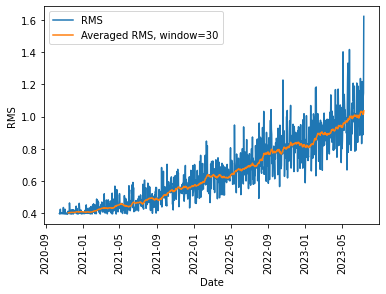

In [393]:
plt.plot(
    mode7_rms_df.Date,
    mode7_rms_df.RMS,
    label='RMS')
plt.plot(
    mode7_rms_df.Date,
    mode7_rms_df.RMS.rolling(window=30).mean(),
    label='Averaged RMS, window=30'
)
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('RMS')
plt.legend()
plt.show()

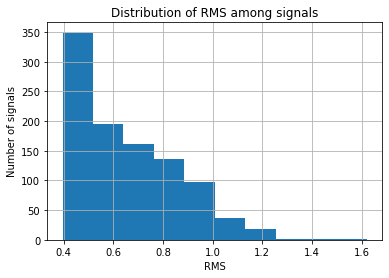

In [12]:
mode7_rms_df['RMS'].hist()
plt.title('Distribution of RMS among signals')
plt.xlabel('RMS'), plt.ylabel('Number of signals')
plt.show()

## Export RMS .csv

In [13]:
# mode7_rms_df.to_csv('D:\Praca Inżynierska\csv_files\MODE7_RMS.csv')

# Frequency Analysis
Digital signals can be analised in time and frequency domain. Algorithms based on the time domain operate directly on samples from digital signal. **Frequency analysis** of the signal is about transforming the signal from time to frequency domain. **Spectrum** of the signal is a visual representation of the frequency, usually the **Frequency analysis** is alternatively called **Spectrum analysis**.

*Jean-Baptiste Joseph Fourier* discovered, that any periodic signal can be represented as **Fourier Series**, that is the sum of trigonometric signals (cosines and sines) characterized by different amplitudes and frequencies.

The operation of transformation the signal from time to frequency domain is called the **Fourier Transform**. In case of discrete signals (digital), we refer to the **Discrete Fourier Transform**.

The practical use of **Fourier Transform** applies to the **Fast Fourier Transform* algorithm.

> *numpy* library contains the ```numpy.fft``` module, in which the ```fft()``` method is implemented

## Magnitude Spectrum
Based on n samples from the digital signal, we can calculate n values for the complex spectrum. Since the spectrum of the signal is complex, we usually analyse the module of the spectrum. The most commonly analysed is the **Magnitude Spectrum**.

> **Magnitude Spectrum** is obtained with the use of ```numpy.abs()``` method, taking the FFT of the time-domain signal as an argument.

In [11]:
def magnitude_spectrum(signal):
    return np.abs(rfft(signal)) / (len(signal) / 2)

## Spectral averaging (Uśrednienie widma) for Magnitude Spectrum
* k = the level of averaging

For ```t=10s``` signal with sampling frequency ```fs=25kHz``` we obtain total number of samples ```N=250,000``` *(fs * t)*.

We segment the signal into ```k=100``` equal ```dt=0.1s``` (t/k) data chunks, containing ```chunk_n_samples=2,500``` *(N / k)* samples.

On each part of the signal, we calculate the **Magnitude Spectrum** and then take an average from it.

We will receive k *spectrum lines* occurring every ```df=10Hz``` *(1 / (t/k))*.

In [15]:
# SINE WAVE SIGNAL PARAMETERS
T = 1   # total signal time
fs = 100 # sampling frequency
N = T * fs  # total number of samples, also defined as len(signal)
dt = 1 / fs
t = np.arange(0, T, dt)
x = np.arange(N)
f = 4 # signal frequency

Based on N signal samples we receive N spectral values, covering the range between 0 and fs, where *fs / 2* is the
**Nyquist frequency**. The difference between these 2 points is *fs / N* (**spectral resolution**).

Based on N signal samples we receive **(N / 2) + 1** values of complex spectrum if N is even, and **(N - 1) / 2** if N
is odd. First value of FFT is a **constant spectral component**, calculated as the sum of signal values. If N is even,
last value of the result represents the spectral component for the Nyquist frequency.

1) Get the time-domain signal

Option 1: Signal based on time domain

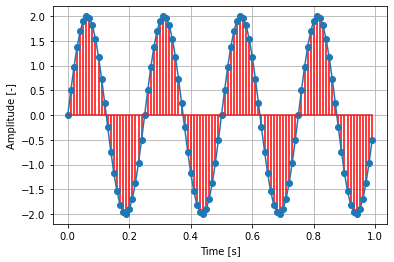

In [16]:
y = 2 * np.sin(2 * np.pi * f * t)
plt.plot(t, y)
plt.stem(t, y, 'r')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [-]')
plt.grid(True)
plt.show()

Option 2: Signal based on number of samples

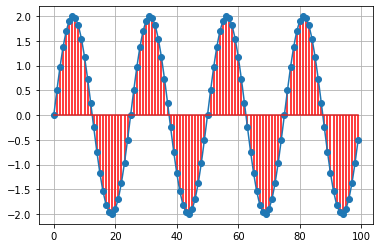

In [17]:
y = 2 * np.sin(2 * np.pi * f * x / fs)
plt.plot(x, y)
plt.stem(x, y, 'r')
plt.grid(True)
plt.show()

### Calculate Spectral Amplitudes for exemplary sine wave
#### 1) Generate signal

In [18]:
y = 2 * np.sin(2 * np.pi * f * t)

#### 2) Fast Fourier Transform (complex output)

In [19]:
y_spectrum = fft(y)

#### 3) Spectral Amplitudes - absolute value of complex numbers

In [20]:
y_magnitude_spectrum = np.abs(y_spectrum)

#### 4) One-sided magnitude spectrum, including DC and fs/2 spectral components

In [21]:
y_real_magnitude_spectrum = np.abs(rfft(y))

#### 5) Scaling with respect to the number of samples
Scaling the spectrum is based on division by half of the FFT's length (N/2), so the spectrum values can be
representative of the energy of each spectral component, since the signal's energy is spread equally into two parts of
spectrum, and we are analysing only one (real) part of them.

In [22]:
y_real_magnitude_spectrum /= (N / 2)

In [23]:
df = 1 / T  # spectral resolution, also defined as fs / N
freq = rfftfreq(N, dt)  # or np.arange(0, (fs / 2) + 1, df)
freq

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

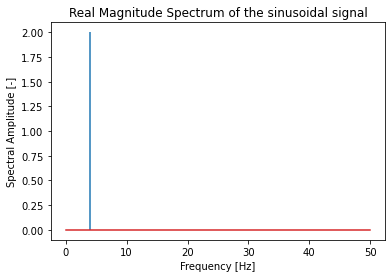

In [24]:
plt.stem(freq, y_real_magnitude_spectrum, markerfmt='none')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Spectral Amplitude [-]')
plt.title('Real Magnitude Spectrum of the sinusoidal signal')
plt.show()

### Spectrum Averaging for the Dataset

In [25]:
# SIGNAL PARAMETERS
k = 100 # level of averaging

fs = 25e3 # sampling frequency
T = 10 # time
dt = 1 / fs # time step
t = np.arange(0, T, dt) # time vector

signal_0001 = data[0] # first signal
N = len(signal_0001) # total number of samples per signal

In [26]:
total_power_0001 = np.sum(np.square(signal_0001)) / N
print('Total power of signal_0001:', total_power_0001)

Total power of signal_0001: 0.15871961797008455


#### Analysis of different solutions to Averaged Spectrum Generator for input time-domain signal.

In [33]:
# MANUAL APPROACH
spectrum_0001_m = fft(signal_0001)    # 2. FFT (complex output)
spectrum_0001_m = np.abs(spectrum_0001_m)   # 3. Spectral amplitudes - absolute value of complex numbers
spectrum_0001_m = spectrum_0001_m[:int(N / 2) + 1] # 4. One-sided spectrum, including DC and fs/2 components
spectrum_0001_m = spectrum_0001_m / (N / 2) # 5. Scaling with respect to the number of samples

f_0001_m = np.linspace(start=0, stop=int(fs / 2), num=int(N / 2) + 1, endpoint=True)

#######################################################################################################################
# FUNCTIONAL APPROACH
spectrum_0001 = rfft(signal_0001)   # 1. FFT on real input values
spectrum_0001 = np.abs(spectrum_0001)   # 2. One-sided Spectral amplitudes, including DC and fs/2 components
spectrum_0001 = spectrum_0001 / (N / 2) # 3. Scaling with respect to the number of samples

df = fs / N
f_0001 = rfftfreq(N, dt)

In [34]:
assert all(np.round(spectrum_0001_m, 8) == np.round(spectrum_0001, 8)) and all(f_0001_m == f_0001), print('Manual approach results in different values than functional.')

Manual FFT approach gives the same results as the Functional approach.

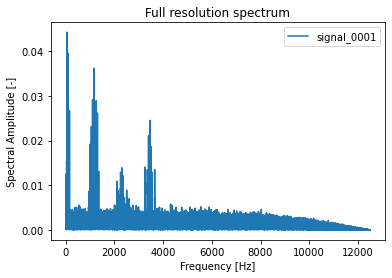

In [35]:
plt.plot(f_0001, spectrum_0001, label='signal_0001')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Spectral Amplitude [-]')
plt.title('Full resolution spectrum')
plt.legend()
plt.show()


In [36]:
signal_0999 = data[-1]

##### Methods used for Spectrum Averaging

Quick overview regarding averaging arrays of different lengths.

I prepared 3 functions, which compute the average value for each row in arrays with different column numbers. 

* First two of them are based on filtering the columns, in which shorter rows have missing values. 

* Last function computes the mean for each row, however there exist 2 cases with either left or right shift, caused by uneven division:
    1. Left shift does not include fs/2
    2. Right shift does not include DC

    The mean is calculated for both shifts, and the amplitudes for missing spectral components are appended to the resulting arrays. Then the final mean is computed on correspoding rows including amplitudes for fs/2 and DC.

In [37]:
spectrum_0999 = magnitude_spectrum(signal_0999)
freq_0999 = rfftfreq(N, dt)

In [38]:
def average(arr):
    return np.mean(list(filter(None, arr)), axis=0)

start1 = time.time()
spectrum_bins = np.array_split(spectrum_0999, k)
averaged_spectrum_1 = list(map(average, zip_longest(*spectrum_bins, fillvalue=None)))
end1 = time.time()
print('Filtering method time:', end1 - start1)

start2 = time.time()
spectrum_bins = np.array_split(spectrum_0999, k)
averaged_spectrum_2 = np.nanmean(np.array(list(zip_longest(*spectrum_bins)), dtype=np.float64), axis=1)
end2 = time.time()
print('Numpy nanmean method time:', end2 - start2)

start3 = time.time()
diff = ((N // 2) + 1) % k
spectrum_bins1 = np.split(spectrum_0999[:-diff], k)
spectrum_bins2 = np.split(spectrum_0999[diff:], k)
avg1 = np.hstack((np.mean(spectrum_bins1, axis=0), spectrum_0999[-1]))
avg2 = np.hstack((np.mean(spectrum_bins2, axis=0), spectrum_0999[0]))
averaged_spectrum_3 = np.mean(np.vstack((avg1, avg2)), axis=0)
end3 = time.time()
print('Manual method time:', end3 - start3)

Filtering method time: 0.05285525321960449
Numpy nanmean method time: 0.03490734100341797
Manual method time: 0.0019943714141845703


The most optimal solution seems to be the approach using *numpy.nanmean* function, which is commonly used for this kind of problem.
The results of manual approach differs significantly from ones obtained from two first approaches.

In [39]:
# SPECTRUM AVERAGING: LEGE ARTIS METHOD
def spectrum_averaging_method_1(signal, k):
    signal = np.split(signal, k)
    return np.mean(
        a=[magnitude_spectrum(signal_fragment) for signal_fragment in signal],
        axis=0)

# SPECTRUM AVERAGING: GENERALIZED METHOD
def spectrum_averaging_method_2(signal, k):
    spectrum = np.array_split(magnitude_spectrum(signal), k)
    return np.nanmean(
        np.array(list(zip_longest(*spectrum)), dtype=np.float64), 
        axis=1)

In [40]:
start_1 = time.time()
averaged_spectrum_0999_1 = spectrum_averaging_method_1(signal_0999, k)
end_1 = time.time()
exec_time_1 = end_1 - start_1
print(f'Execution time of Method 1: {exec_time_1}s')


start_2 = time.time()
averaged_spectrum_0999_2 = spectrum_averaging_method_2(signal_0999, k)
end_2 = time.time()
exec_time_2 = end_2 - start_2
print(f'Execution time of Method 2: {exec_time_2}s')


# freq_0999 = np.arange(start=0, stop=(N // (2 * k) + 1), step=(N / ))
averaged_freq_0999 = rfftfreq(int(N / k), dt)

Execution time of Method 1: 0.0069811344146728516s
Execution time of Method 2: 0.05884361267089844s


In [41]:
time_delta = abs(exec_time_2 - exec_time_1)
if exec_time_2 < exec_time_1:
    print(f'Method 2 is faster by {np.round(time_delta * 100 / exec_time_1, 2)} %')
else:
    print(f'Method 1 is faster by {np.round(time_delta * 100 / exec_time_2, 2)} %')

Method 1 is faster by 88.14 %


###### Time of Method 1

In [42]:
cProfile.run('spectrum_averaging_method_1(signal_0999, k)')

         1939 function calls (1837 primitive calls) in 0.006 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(array_split)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(mean)
      100    0.000    0.000    0.003    0.000 <__array_function__ internals>:2(rfft)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(split)
      101    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(swapaxes)
      100    0.002    0.000    0.005    0.000 <ipython-input-14-515674863c8f>:1(amplitude_spectrum)
        1    0.000    0.000    0.006    0.006 <ipython-input-39-f49cd9ea5e10>:2(spectrum_averaging_method_1)
        1    0.000    0.000    0.005    0.005 <ipython-input-39-f49cd9ea5e10>:5(<listcomp>)
        1    0.000    0.000    0.006    0.006 <string>:1(<module>)
      100    0.000    0

###### Time of Method 2

In [43]:
cProfile.run('spectrum_averaging_method_2(signal_0999, k)')

         879 function calls (775 primitive calls) in 0.056 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(array_split)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:2(nanmean)
        1    0.000    0.000    0.009    0.009 <__array_function__ internals>:2(rfft)
        2    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(sum)
      101    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(swapaxes)
        1    0.004    0.004    0.013    0.013 <ipython-input-14-515674863c8f>:1(amplitude_spectrum)
        1    0.021    0.021    0.056    0.056 <ipython-input-39-f49cd9ea5e10>:9(spectrum_averaging_method_2)
        1    0.000    0.000    0.056    0.056 <string>:1(<module>)
        1    0.000    0.000  

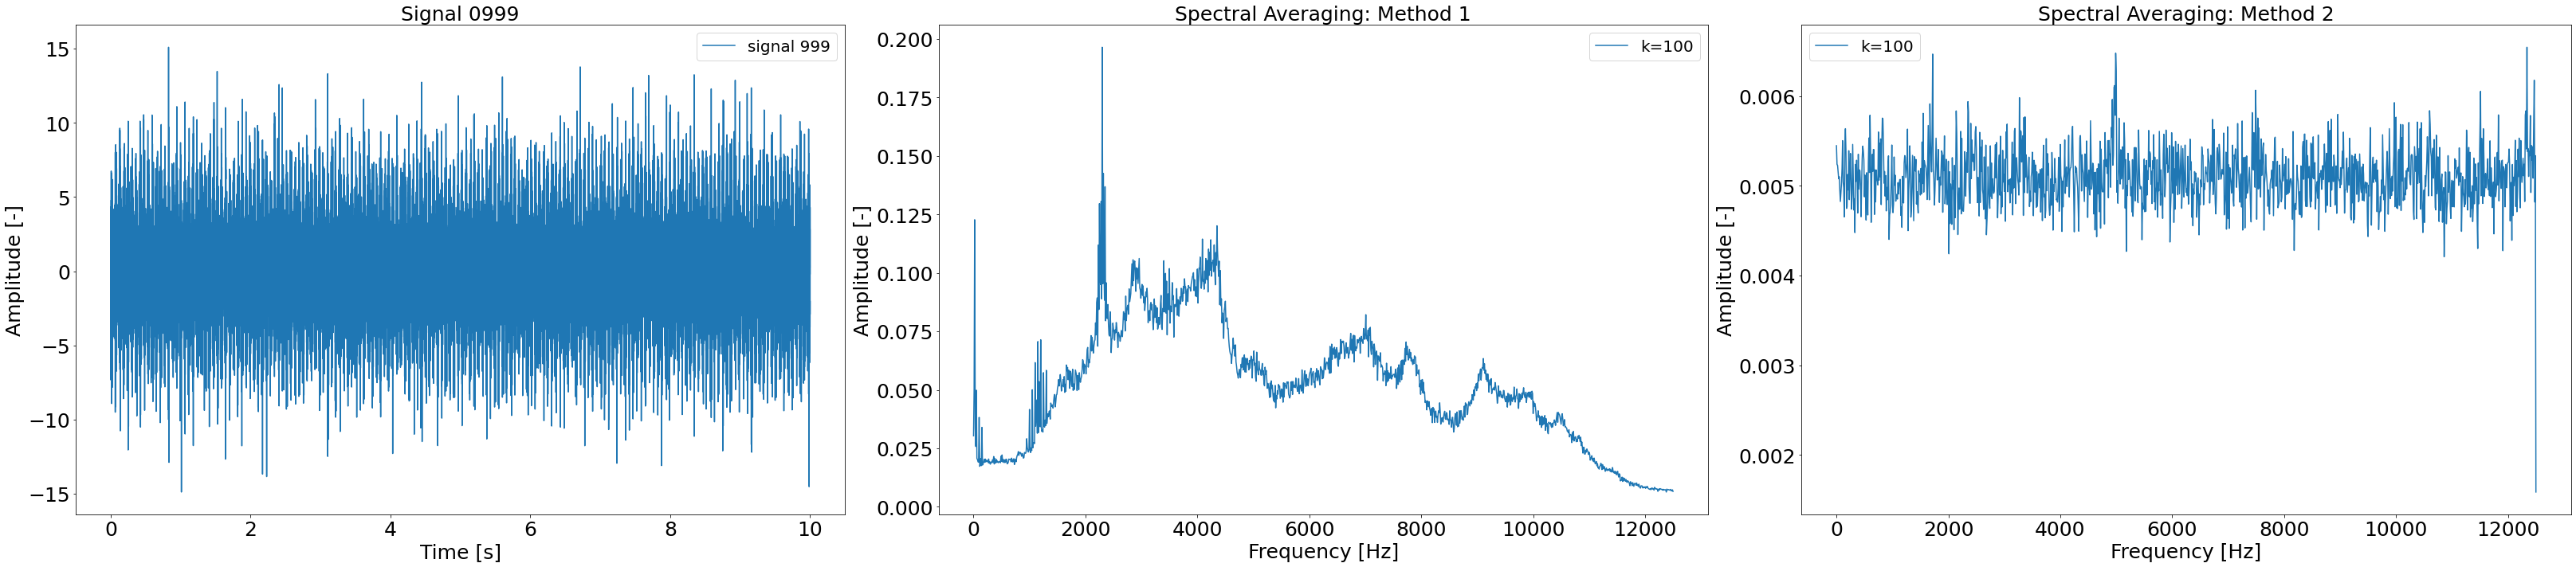

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(45, 10))

ax[0].plot(t, signal_0999, label='signal 999')
ax[0].set_xlabel('Time [s]', fontsize=25)
ax[0].set_ylabel('Amplitude [-]', fontsize=25)
ax[0].set_title('Signal 0999', size=25)
ax[0].tick_params(axis='both', which='major', labelsize=25)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].legend(fontsize=20)

ax[1].plot(averaged_freq_0999, averaged_spectrum_0999_1, label='k=100')
# ax[1].stem(averaged_freq_0999, averaged_spectrum_0999_1, 'r', markerfmt='none')
ax[1].set_xlabel('Frequency [Hz]', fontsize=25), ax[1].set_ylabel('Amplitude [-]', fontsize=25)
ax[1].set_title('Spectral Averaging: Method 1', size=25)
ax[1].tick_params(axis='both', which='major', labelsize=25)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
# ax[1].set_ylim((0, 0.065))
ax[1].legend(fontsize=20, loc='upper right')

ax[2].plot(averaged_freq_0999, averaged_spectrum_0999_2, label='k=100')
# ax[2].stem(averaged_freq_0999, averaged_spectrum_0999_2, 'r', markerfmt='none')
ax[2].set_xlabel('Frequency [Hz]', fontsize=25), ax[2].set_ylabel('Amplitude [-]', fontsize=25)
ax[2].set_title('Spectral Averaging: Method 2', size=25)
ax[2].tick_params(axis='both', which='major', labelsize=25)
ax[2].tick_params(axis='both', which='minor', labelsize=15)
ax[2].legend(fontsize=20)

plt.tight_layout()
plt.savefig('signal_0999.jpg', bbox_inches='tight')
plt.show()

In [47]:
N_0999 = len(signal_0999)
overlap_0999 = 0.5
k_exp = np.round(np.log10(k)).astype(int)
nperseg_0999 = int(k / overlap_0999) - 2 ** (k_exp - 1)    # in order to obtain k-average values
window_0999 = np.hamming(nperseg_0999)
noverlap_0999 = int(overlap_0999 * nperseg_0999)

#### Welch's estimate
##### Power Spectrum Density


In [48]:
f_den_0999, Pxx_den_0999 = welch(signal_0999,
                                 fs=fs,
                                 nperseg=nperseg_0999,
                                 noverlap=noverlap_0999,
                                 scaling='density',
                                 average='mean')

##### Power Spectrum

In [49]:
f_spec_0999, Pxx_spec_0999 = welch(signal_0999,
                                 fs=fs,
                                 nperseg=nperseg_0999,
                                 noverlap=noverlap_0999,
                                 scaling='spectrum',
                                 average='mean')

In [50]:
assert Pxx_den_0999.shape[0] == Pxx_spec_0999.shape[0] == 100, f'The Averaged Spectrum does not contain {k} values!'

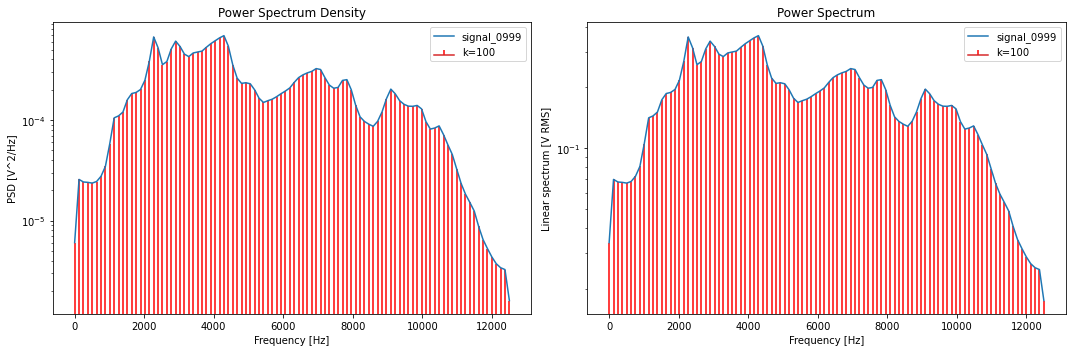

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].semilogy(f_den_0999, Pxx_den_0999, label='signal_0999')
ax[0].stem(f_den_0999, Pxx_den_0999, 'r', label=f'k={k}', markerfmt='none')
ax[0].set_title('Power Spectrum Density')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('PSD [V^2/Hz]')
ax[0].legend(loc='upper right')

ax[1].semilogy(f_spec_0999, np.sqrt(Pxx_spec_0999), label='signal_0999')
ax[1].stem(f_spec_0999, np.sqrt(Pxx_spec_0999), 'r', label=f'k={k}', markerfmt='none')
ax[1].set_title('Power Spectrum')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Linear spectrum [V RMS]')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.savefig('welch.jpg', bbox_inches='tight')
plt.show()

#### Conclusion:
Method 1 (Lege Artis) is a proper method for Spectrum Averaging. Moreover it is faster by ~75%.

In [6]:
def spectrum_averaging(signal, k=100):
    return np.mean(
        a=[magnitude_spectrum(signal_fragment) for signal_fragment in np.split(signal, k)],
        axis=0)

### Calculate the Averaged Spectrum for each signal 
For different value of *k*:

* no averaging
* k = 100
* k = 1,000
* k = 2,500

And create DataFrame for each separate case.


##### Function plotting averaged spectrum for the first and last signals.

In [7]:
def plot_averaged_spectrums(averaged_spectrum, freq, k):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    ax[0].plot(freq, averaged_spectrum[0], label=f'k={k}')
    ax[0].stem(freq, averaged_spectrum[0], 'r', markerfmt='None')
    ax[0].set_title('Averaged Spectrum for Signal 1')
    ax[0].set_xlabel('Frequency [Hz]')
    ax[0].set_ylabel('Amplitude[-]')
    ax[0].legend(loc='upper right')

    ax[1].plot(freq, averaged_spectrum[-1], label=f'k={k}')
    ax[1].stem(freq, averaged_spectrum[-1], 'r', markerfmt='None')
    ax[1].set_title('Averaged Spectrum for Signal 999')
    ax[1].set_xlabel('Frequency [Hz]')
    ax[1].set_ylabel('Amplitude[-]')
    ax[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    No averaging

In [145]:
mode7_averaged_spectrum = np.vstack([magnitude_spectrum(signal) for signal in data])
freq = rfftfreq(N, dt)

    k = 100

In [12]:
k = 100

mode7_averaged_spectrum_1e2 = np.vstack([spectrum_averaging(signal, k) for signal in data])
freq_1e2 = np.asarray(rfftfreq(int(N / k), dt), dtype=np.int16)

mode7_averaged_spectrum_1e2_df = pd.DataFrame(
    data=np.column_stack((timestamps, mode7_averaged_spectrum_1e2)),
    index=signal_names,
    columns=['Date'] + [f'{i} Hz' for i in freq_1e2]
)

mode7_averaged_spectrum_1e2_df.head()

,Date,0 Hz,10 Hz,20 Hz,30 Hz,40 Hz,50 Hz,60 Hz,70 Hz,80 Hz,...,12410 Hz,12420 Hz,12430 Hz,12440 Hz,12450 Hz,12460 Hz,12470 Hz,12480 Hz,12490 Hz,12500 Hz
signal_1,2020-10-16 10:51:26,0.0143542,0.018297,0.0193235,0.0198293,0.0174691,0.0473386,0.017116,0.0160276,0.0160458,...,0.000482294,0.000474037,0.000399138,0.000402377,0.000367959,0.000360439,0.000340541,0.000338153,0.0003366,0.000310598
signal_2,2020-10-17 10:51:26,0.0140179,0.0157107,0.0195969,0.0173899,0.0182948,0.0498373,0.015113,0.0151605,0.014963,...,0.000481032,0.000454418,0.000413103,0.00040666,0.000328192,0.000342004,0.000313631,0.000302251,0.000286565,0.000266196
signal_3,2020-10-18 10:51:26,0.0144314,0.0178543,0.0240037,0.0187601,0.0164995,0.0423391,0.0157937,0.0160615,0.0149531,...,0.00048407,0.00046654,0.000406935,0.00041891,0.000388589,0.000400445,0.000374103,0.000355013,0.000361843,0.000343357
signal_4,2020-10-19 10:51:26,0.0148578,0.0161955,0.0213087,0.0208587,0.0168486,0.0496316,0.0165767,0.0150535,0.0155668,...,0.00091947,0.000912829,0.000910851,0.000778156,0.00079877,0.000749436,0.000831698,0.000788337,0.000831996,0.00076883
signal_5,2020-10-20 10:51:26,0.0141319,0.0175383,0.0219247,0.0192725,0.0186413,0.0494203,0.0145962,0.0147011,0.0149469,...,0.000473225,0.00042785,0.000413953,0.000402452,0.000381285,0.000364688,0.000332639,0.000338472,0.000325536,0.000300789


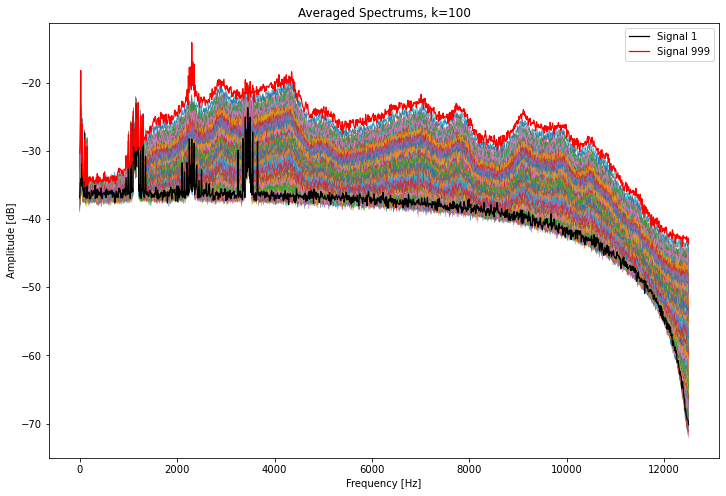

In [54]:
plt.figure(figsize=(12, 8))
for i in range(1, n - 1):
    plt.plot(freq_1e2, 20 * np.log10(mode7_averaged_spectrum_1e2[i]), linewidth=0.5)

plt.plot(freq_1e2, 20 * np.log10(mode7_averaged_spectrum_1e2[0]), color='k', linewidth=1.25, label='Signal 1')
plt.plot(freq_1e2, 20 * np.log10(mode7_averaged_spectrum_1e2[-1]), color='r', linewidth=1.25, label='Signal 999')
plt.title('Averaged Spectrums, k=100')
plt.xlabel('Frequency [Hz]'), plt.ylabel('Amplitude [dB]')
plt.legend()
plt.show()

    k = 1000

In [13]:
k = 1000
mode7_averaged_spectrum_1e3 = np.vstack([spectrum_averaging(signal, k) for signal in data])
freq_1e3 = np.asarray(rfftfreq(int(N / k), dt), dtype=np.int16)

mode7_averaged_spectrum_1e3_df = pd.DataFrame(
    data=np.column_stack((timestamps, mode7_averaged_spectrum_1e3)),
    index=signal_names,
    columns=['Date'] + [f'{i} Hz' for i in freq_1e3]
)

mode7_averaged_spectrum_1e3_df.head()

,Date,0 Hz,100 Hz,200 Hz,300 Hz,400 Hz,500 Hz,600 Hz,700 Hz,800 Hz,...,11600 Hz,11700 Hz,11800 Hz,11900 Hz,12000 Hz,12100 Hz,12200 Hz,12300 Hz,12400 Hz,12500 Hz
signal_1,2020-10-16 10:51:26,0.0727712,0.0629118,0.0541506,0.0496917,0.0497265,0.0491771,0.0507063,0.0487079,0.0519537,...,0.0110469,0.010021,0.0091553,0.00792514,0.00679552,0.00608417,0.00503942,0.00420634,0.00356775,0.00326402
signal_2,2020-10-17 10:51:26,0.0484119,0.0787586,0.0485939,0.0498858,0.0482106,0.0486511,0.0504815,0.0494178,0.0515349,...,0.0110884,0.0101347,0.00914882,0.00775894,0.00700472,0.00584426,0.0049152,0.00425094,0.0036039,0.00325012
signal_3,2020-10-18 10:51:26,0.0671878,0.0610574,0.0568033,0.0487737,0.0507156,0.0482232,0.0499548,0.0504671,0.0511923,...,0.0108377,0.0102516,0.00901595,0.00785116,0.00700809,0.00592922,0.00491513,0.00414309,0.00343721,0.00315086
signal_4,2020-10-19 10:51:26,0.081538,0.0632226,0.05473,0.0486404,0.0494949,0.0497386,0.0497472,0.0510883,0.0530707,...,0.0115983,0.0107099,0.00953653,0.00842112,0.00747253,0.00642878,0.0055686,0.00473164,0.00428473,0.00388757
signal_5,2020-10-20 10:51:26,0.0611301,0.066952,0.0556817,0.0501278,0.0513337,0.0503203,0.051132,0.0527323,0.0545966,...,0.0108182,0.0103038,0.00930043,0.00825036,0.00716706,0.00616626,0.0052192,0.00434368,0.00372343,0.00340745


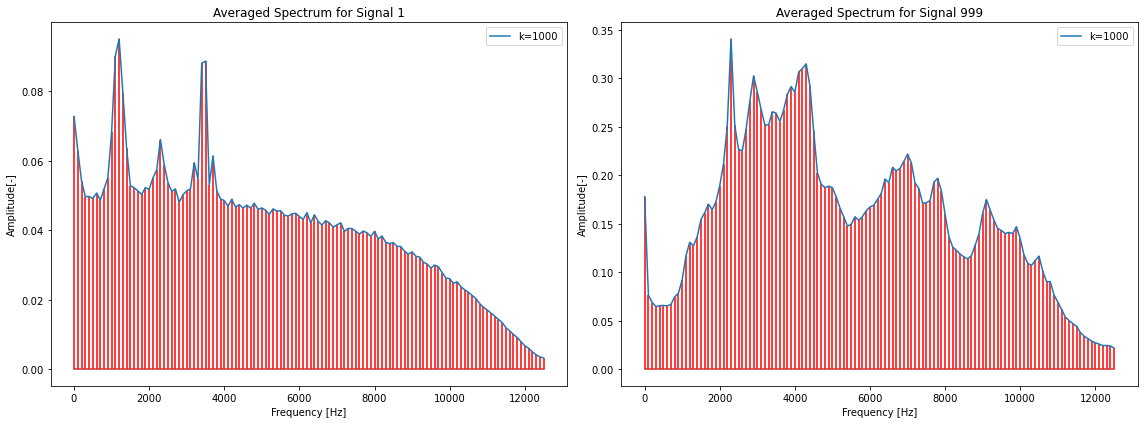

In [152]:
plot_averaged_spectrums(mode7_averaged_spectrum_1e3, freq_1e3, k=1000)

    k = 2500

In [139]:
k = 2500
mode7_averaged_spectrum_25e2 = np.vstack([spectrum_averaging(signal, k) for signal in data])
freq_25e2 = np.asarray(rfftfreq(int(N / k), dt), dtype=np.int16)

mode7_averaged_spectrum_25e2_df = pd.DataFrame(
    data=np.column_stack((timestamps, mode7_averaged_spectrum_25e2)),
    index=signal_names,
    columns=['Date'] + [f'{i} Hz' for i in freq_25e2]
)

mode7_averaged_spectrum_25e2_df.head()

,Date,0 Hz,250 Hz,500 Hz,750 Hz,1000 Hz,1250 Hz,1500 Hz,1750 Hz,2000 Hz,...,10250 Hz,10500 Hz,10750 Hz,11000 Hz,11250 Hz,11500 Hz,11750 Hz,12000 Hz,12250 Hz,12500 Hz
signal 1,2020-10-16 10:51:26,0.0999978,0.0837711,0.0801066,0.0813608,0.113484,0.132045,0.0850487,0.0796299,0.0827996,...,0.0384143,0.0352024,0.031393,0.0278038,0.023637,0.0198763,0.0159632,0.0121049,0.00905562,0.00735251
signal 2,2020-10-17 10:51:26,0.0970985,0.0833354,0.0789159,0.0821838,0.114344,0.132689,0.0846304,0.0802694,0.0812123,...,0.0379079,0.0351497,0.0318776,0.0283026,0.0242552,0.0200289,0.0160719,0.0123844,0.00926986,0.00766254
signal 3,2020-10-18 10:51:26,0.0993102,0.0820418,0.0783156,0.0804714,0.112519,0.131721,0.0845557,0.0805932,0.0843257,...,0.0388207,0.0349208,0.0314694,0.0276606,0.0241695,0.0202574,0.0160745,0.012399,0.00922013,0.00755415
signal 4,2020-10-19 10:51:26,0.0950499,0.087187,0.0802255,0.0839691,0.115012,0.130125,0.0875039,0.0851158,0.0875342,...,0.0418004,0.0384716,0.0349178,0.0299677,0.0253456,0.020888,0.0167819,0.0132876,0.0101906,0.0085379
signal 5,2020-10-20 10:51:26,0.101466,0.0829907,0.0801352,0.083309,0.114897,0.133632,0.084224,0.0787334,0.0822445,...,0.0387318,0.0345765,0.0313468,0.0279166,0.0242244,0.0199516,0.0165345,0.012633,0.00964536,0.00793707


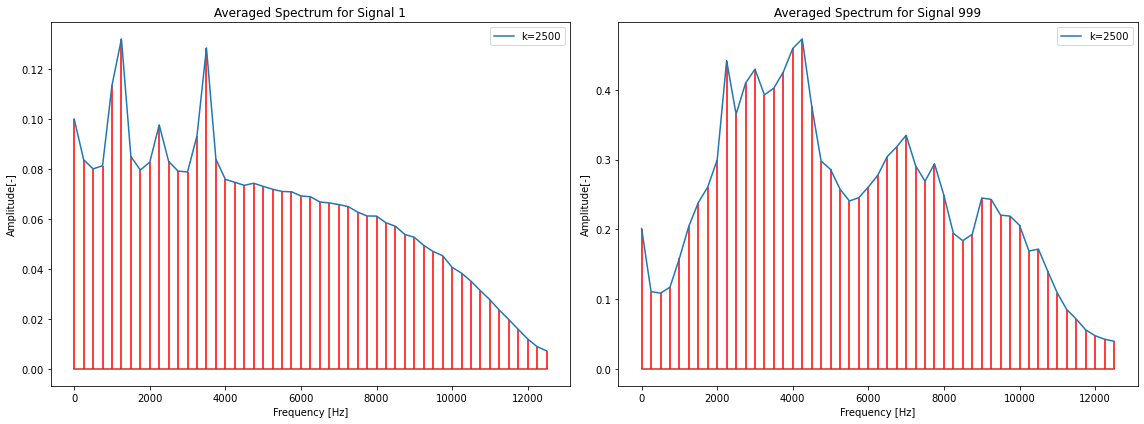

In [153]:
plot_averaged_spectrums(mode7_averaged_spectrum_25e2, freq_25e2, k=2500)

## Clustering-Based Anomaly Detection
K-means is a widely used clustering algorithm for both classification and regression problems. It creates ‘k’ similar clusters of data points and can be used as either supervised or unsupervised learning technique. Data instances that lay outside of the formed clusters may be potentially treated as anomalies in time series. 
In order to find the optimal number of clusters for the K-Means clustering, the elbow method is used.

In [385]:
from sklearn.cluster import KMeans

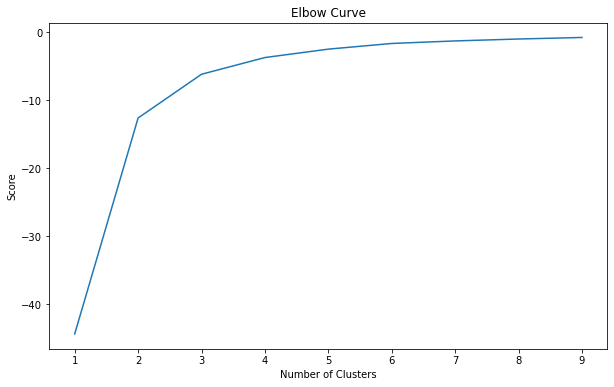

In [399]:
X = mode7_rms.reshape(-1, 1)

n_clusters = range(1, 10)
k_means = [KMeans(n_clusters=n).fit(X) for n in n_clusters]
scores = [k_means[i].score(X) for i in range(len(k_means))]

plt.figure(figsize=(10,6))
plt.plot(n_clusters, scores)
plt.xlabel('Number of Clusters'), plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the elbow curve, we see that the graph starts to flatten after 3 clusters, thus applying higher number of clusters will not explain the variance.

In [400]:
k_means_model = KMeans(n_clusters=3)
k_means_model.fit(X)

KMeans(n_clusters=3)

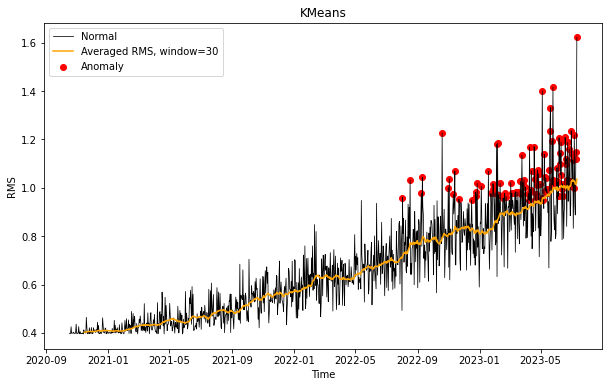

In [401]:
def get_distance_from_point(data, model):
    distance = pd.Series(dtype=np.float64)
    for i in range(len(data)):
        Xa = np.array(data[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        distance.at[i] = np.linalg.norm(Xa - Xb)
    return distance

outliers_fraction = 1e-1

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = get_distance_from_point(X, k_means_model)
number_of_outliers = int(outliers_fraction * len(distance))
threshold = distance.nlargest(number_of_outliers).min() # nlargest returns the largest n elements


mode7_rms_df['Anomaly'] = [1 if x >= threshold else 0 for x in distance]

# visualisation of anomaly with cluster view
anomalies = [mode7_rms_df['RMS'].loc[signal_name] if anomaly == 1 else None for signal_name, anomaly in mode7_rms_df['Anomaly'].items()]

plt.figure(figsize=(10,6))
plt.scatter(timestamps, anomalies, color='red', label='Anomaly')
plt.plot(timestamps, X, color='k', linewidth=0.75, label='Normal')
plt.plot(
    mode7_rms_df.Date,
    mode7_rms_df.RMS.rolling(window=30).mean(),
    label='Averaged RMS, window=30',
    color='orange'
)
plt.xlabel('Time'), plt.ylabel('RMS')
plt.title('KMeans')
plt.legend()
plt.show()

K-Means clustering is definitely not the algorithm we are searching for finding the anomalies in signals RMS. We need a way more sophisticated algorithm.

### Spectrogram
Function get_spectrograms will compute the spectrogram for each signal.

    Function manually computing the Absolute Magnitude for each STFT.

In [22]:
def magnitude_spectrum_stft(signal, k):
    Sxx = np.column_stack([magnitude_spectrum(signal_fragment) for signal_fragment in np.split(signal, k)])
    return Sxx

    Function generating the spectrogram for each signal

In [23]:
def get_magnitude_spectrum_stft(data, k):
    magnitude_spectrum = []
    for signal in data:
        Sxx = magnitude_spectrum_stft(signal, k)   
        magnitude_spectrum.append(Sxx)    
    
    f = rfftfreq(int(N / k), dt)
    t = np.linspace(0, T, k)
    
    return f, t, np.asarray(magnitude_spectrum)
    

In [24]:
k = 100
f_spec, t_spec, mode7_Sxx_1e2 = get_magnitude_spectrum_stft(data, k=100)

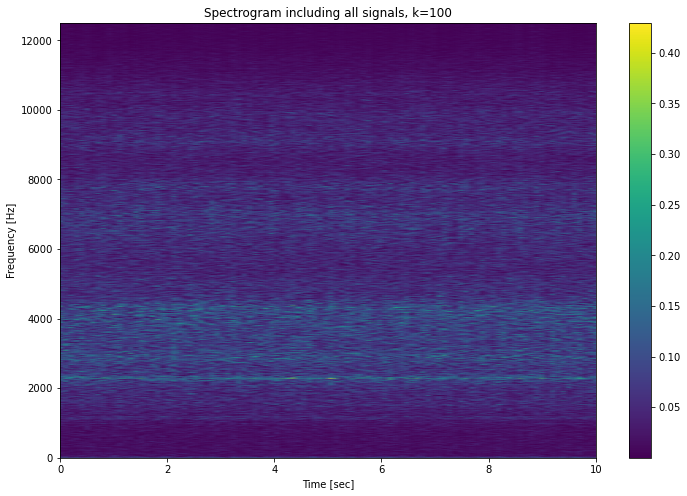

In [25]:
plt.figure(figsize=(12, 8))
for Sxx in mode7_Sxx_1e2:
    plt.pcolormesh(t_spec, f_spec, Sxx, shading='gouraud')

plt.title('Spectrogram including all signals, k=100')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.savefig('spectrogram_1e2.png')
plt.show()

In [413]:
mode7_averaged_Sxx_1e2 = np.vstack([np.mean(Sxx, axis=1) for Sxx in mode7_Sxx_1e2])

In [414]:
assert all(np.round(mode7_averaged_Sxx_1e2[0], 2) == np.round(mode7_averaged_spectrum_1e2[0], 2)), 'Averaging the spectrogram results in different averaged magnitude spectrum'

### Conclusion:
Averaging the spectrogram results in the same Averaged Magnitude Spectrum as mathematical approach.  

### Prepare data for training


In [352]:
k = 100
M = int(N / (2 * k)) + 1 # number of Sxx per signal
n_signals = 100

idx = np.linspace(0, n - 1, n_signals, dtype=int)
values_X = mode7_averaged_spectrum_1e2[idx].flatten()
date_X = np.asarray(timestamps)[idx]

values_ticks = np.arange(M * n_signals)
date_ticks = [date_X[i // M].strftime('%Y-%m-%d') if i % M == 0 else None for i in range(n_signals * M)]

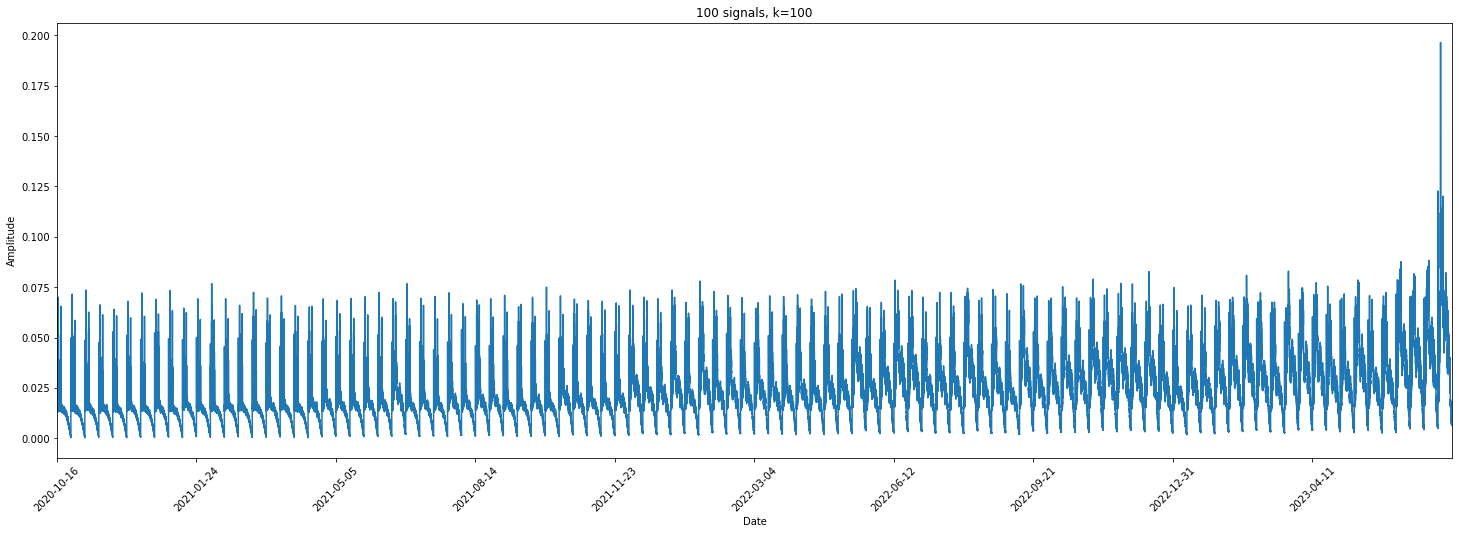

In [237]:
plt.figure(figsize=(25, 8))
plt.plot(values_X)
plt.xlim((0, M * n_signals))
plt.xticks(ticks=values_ticks, labels=date_ticks, rotation=45)
plt.locator_params(nbins=10)
plt.title(f'{n_signals} signals, k={k}')
plt.xlabel('Date'), plt.ylabel('Amplitude')
plt.show()

# Isolation Forest for Anomaly Detection
*Isolation Forest* detects the anomalies, based on the nature and characteristics of an anomaly - it is an outlaying, different data point. 

The *Isolation Forest* does not use any form of distance or density measurements. 

* *outliers_fraction* determines the proportion of outliers and can be defined also as the dataset contamination.
* fitting and predicting on data performs outlier detection, returning 1 for anomaly and -1 for normal piece of data.

In [362]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

In [353]:
scaler = StandardScaler()
values_scaled = scaler.fit_transform(values_X.reshape(-1, 1))

In [357]:
outliers_fraction = 0.0025

# initiate model
iso_forest =  IsolationForest(
    contamination=outliers_fraction,
    bootstrap=False,
)

# train model
iso_forest.fit(values_scaled) 

# predict anomalies
anomalies = iso_forest.predict(values_scaled)

# find values for anomalies
anomaly_points = [values_scaled[i] if A == -1 else None for i, A in enumerate(anomalies)]

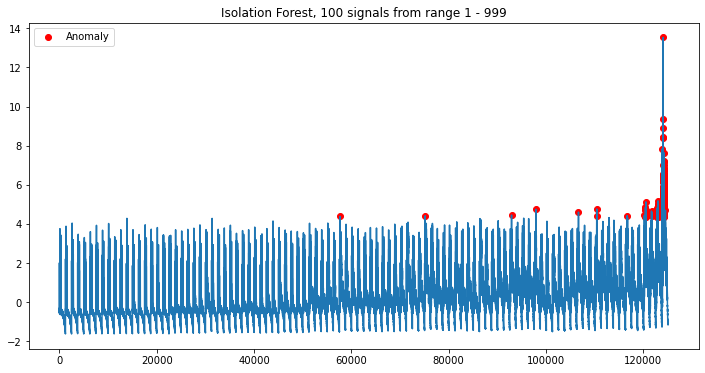

In [360]:
plt.figure(figsize=(12, 6))
plt.plot(values_ticks, values_scaled.flatten())
plt.scatter(values_ticks, anomaly_points, color='r', label='Anomaly')
plt.title('Isolation Forest, 100 signals from range 1 - 999')
plt.legend()
plt.show()

# SVM
Support Vector Machine is commonly identified as supervised learning technique, however Sklearn's OneClassSVM may be handy in case of finding the anomalies in unsupervised learning manner. OneClassSVM learns a decision function, while classifying the new data as similiar or different from the previous data. 

* setting kernel='rbf' enables SVM to use a non-linear function to project hyperspace to higher dimension.
* gamma (kernel coefficient) is a parameter of the RBF kernel type and controls the influence of individual training samples (how smooth the model is).
* similiar to Isolation Forests, -1 is returned as anomaly and 1 is normal.

In [ ]:
outliers_fraction = 0.01

# initiate the model
oc_svm = OneClassSVM(
    nu=outliers_fraction,
    kernel='rbf',
    gamma='auto')

# train the model
oc_svm.fit(values_scaled)

# predict anomalies
anomalies = oc_svm.predict(values_scaled)

# find values for anomalies
anomaly_points = [values_scaled[i] if A == -1 else None for i, A in enumerate(anomalies)]

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(values_ticks, values_scaled.flatten())
plt.scatter(values_ticks, anomaly_points, color='r', label='Anomaly')
plt.title('One Class SVM, 100 signals from range 1 - 999')
plt.legend()
plt.show()